<a href="https://colab.research.google.com/github/Rocknroll-nerd/statistic/blob/main/BayesianTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arviz
!pip install pymc3 --upgrade

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.2)


In [ ]:
import pymc3 as pm
import arviz as az
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
import numpy as np
from sklearn import datasets
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

## Changing point detection

Одна из возможных задач, которые могут возникать при анализе временных рядов - это так называемое определение поворотных точек (changing point detection). В трейдинге, например, на таких поворотных точках можно строить стратегии и зарабатывать миллионы. В экономике вообще можно так анализировать последствия всяких политик. Но это если про деньги и скучно. Давайте про жизнь:)

Допустим, вы познакомились с мальчиком, все идет отлично, смайлики, кошечки, собачки, сообщения летят без остановки. Проходит время, и что-то вам стало казаться что пожар погас. Но мы же не с филфака девочки, вообще много теперь всего знаем и можем провести расследование. Можем?
Соберем данные и выясним а погас ли, а если погас то когда, а насколько точно погас, можем ли разжечь выяснять не будем:)

Вот вам данные, надо выяснить!

In [ ]:
with pm.Model() as messages:
    text = pm.Poisson("mu", 10)
    trace = pm.sample(365)

Only 365 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 3460/3460 [00:00<00:00, 10445.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
trace['mu']

array([ 6,  6,  6, ..., 13, 11, 11])

In [ ]:
with pm.Model() as messages:
    text = pm.Poisson("mu", 10)
    tau1 = pm.DiscreteUniform('tau1', 0, 100)
    trace = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau1]
>Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 8023.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
trace['tau1']

array([89, 23, 87, ..., 38, 72, 51])

In [ ]:
def generate_number(mu1, mu2, tau = 480, N = 1000):
    text1 = stats.poisson(mu1).rvs(tau)
    text2 = stats.poisson(mu2).rvs(N-tau)
    return pd.DataFrame(np.hstack((text1,text2)), columns=['number'])

In [ ]:
df = generate_number(15, 12, tau = 48, N = 100)
df.head()

,number
0,11
1,12
2,21
3,14
4,16


In [ ]:
df.shape[0], df.number.mean()

(100, 14.03)

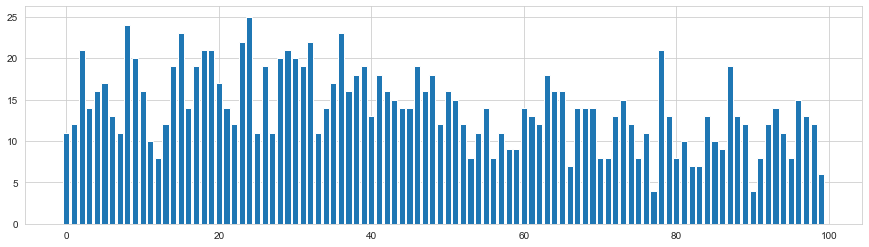

In [ ]:
plt.figure(figsize = (15,4))
plt.bar(df.index[:100],df.number);

In [ ]:
with pm.Model() as chPoint:
    n_count_data = df.shape[0]
    #можно и так например
    lam1 = pm.Exponential('lam1', 1/df.number.mean())
    lam2 = pm.Exponential('lam2', 1/df.number.mean())
    #alpha = 1./15.

    #lam1, lam2 = np.random.exponential(scale=1/alpha, size=2)

    tau = pm.DiscreteUniform('tau', 0, df.shape[0]-1)
    idx = np.arange(n_count_data) # Index
    #lambda_ = pm.Deterministic('lam_',pm.math.switch(tau > idx, lam1, lam2))
    lambda_ = pm.math.switch(tau > idx, lam1, lam2)
    y = pm.Poisson("y", lambda_, observed=df.number)
    trace_chPoint = pm.sample(2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lam2, lam1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 5921.53draws/s]
The acceptance probability does not match the target. It is 0.8844379811664149, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2ba1c668>,
      dtype=object)

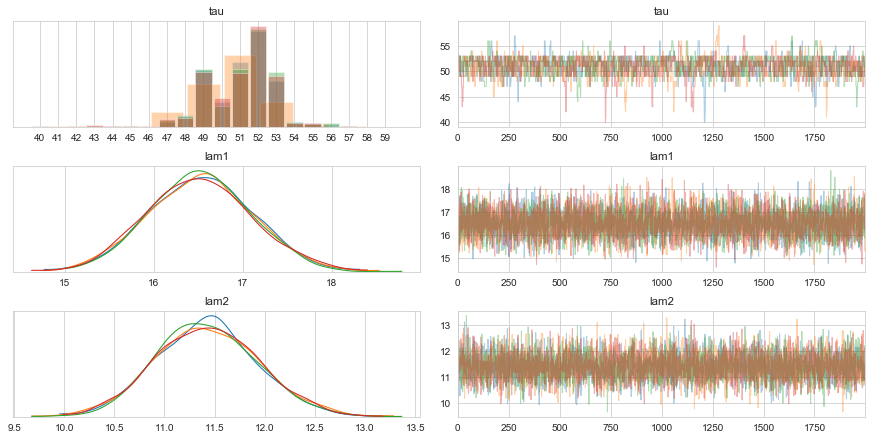

In [ ]:
#varnames = ['~lam_']
az.plot_trace(trace_chPoint);

# А теперь немножко данных про которые мы не знаем

In [ ]:
messages = pd.read_csv("https://raw.githubusercontent.com/iknyazeva/BayesData/master/txtdata.csv", header=None, names = ["number"])

In [ ]:
messages.head()

,number
0,13.0
1,24.0
2,8.0
3,24.0
4,7.0


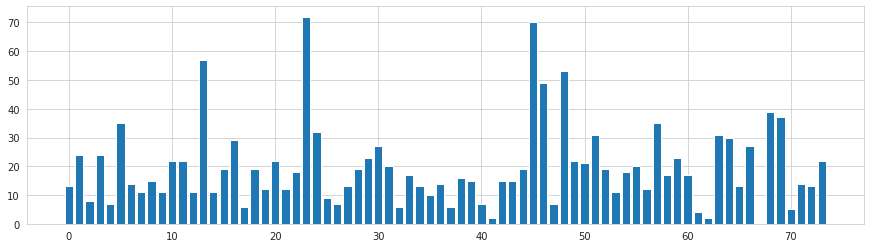

In [ ]:
plt.figure(figsize = (15,4))
plt.bar(messages.index, messages.number);

In [ ]:
with pm.Model() as messPoint:
    n_count_data = messages.shape[0]
    #можно и так например
    lam1 = pm.Exponential('lam1', 1/messages.number.mean())
    lam2 = pm.Exponential('lam2', 1/messages.number.mean())
    #alpha = 1./15.

    #lam1, lam2 = np.random.exponential(scale=1/alpha, size=2)

    tau = pm.DiscreteUniform('tau', 0, messages.shape[0]-1)
    idx = np.arange(n_count_data) # Index
    #lambda_ = pm.Deterministic('lam_',pm.math.switch(tau > idx, lam1, lam2))
    lambda_ = pm.math.switch(tau > idx, lam1, lam2)
    y = pm.Poisson("y", lambda_, observed=messages.number)
    trace_mess = pm.sample(2000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lam2, lam1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
az.summary(trace_mess)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,44.298,0.810,43.000,45.000,0.032,0.023,623.0,623.0,654.0,682.0,1.0
lam1,17.743,0.646,16.521,18.914,0.011,0.008,3415.0,3415.0,3406.0,2736.0,1.0
lam2,22.707,0.906,21.001,24.377,0.017,0.012,2874.0,2874.0,2864.0,2843.0,1.0


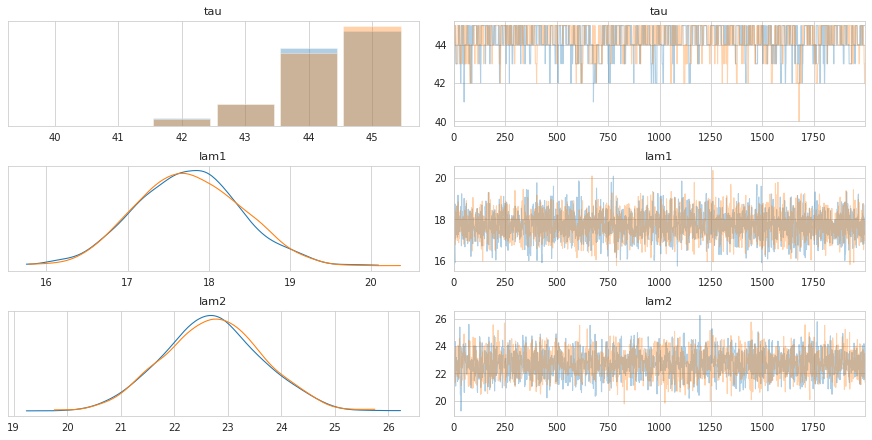

In [ ]:
az.plot_trace(trace_mess);

что-то случилось с 44 на 45 день, количество сообщений  увеличилось примерно на 5 ( с 18 до 22-23)

# A/B testing 

Или A/B тестирование, популярное в маркетинге. Внедряется какое-то изменение и затем нужно выяснить, а изменилось ли что-то с этим внедрением. История за кадром: идет работа над страничкой с платежным шлюзом, есть два дизайна, в течении месяца пользователей шлют то туда то сюда в случайном порядке (GRP B, GRP  A). Вопрос в следующем, какой вариант лучше, насколько?  

In [ ]:
ab_test = pd.read_csv('https://assets.datacamp.com/production/repositories/1646/datasets/2751adce60684a03d8b4132adeadab8a0b95ee56/AB_testing_exercise.csv')
ab_test.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [ ]:
spent_group_a=ab_test[ab_test['group']=='GRP A'].spent.values
spent_group_b = ab_test[ab_test['group']=='GRP B'].spent.values

In [ ]:
#не уверена, лучше ли для каждой группы делать отдельную модель или одну
with pm.Model() as gr_a_b:
    n_count_data = ab_test.shape[0]

    lam1 = pm.Exponential('lam1', 1/spent_group_a.mean())
    lam2 = pm.Exponential('lam2', 1/spent_group_b.mean())

    tau = pm.DiscreteUniform('tau', 0, ab_test.shape[0]-1)
    idx = np.arange(n_count_data) # Index
    #lambda_ = pm.Deterministic('lam_',pm.math.switch(tau > idx, lam1, lam2))
    lambda_ = pm.math.switch(tau > idx, lam1, lam2)
    y = pm.Poisson("y", lambda_, observed=ab_test['spent'])
    trace_ab = pm.sample(2000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lam2, lam1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 138 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


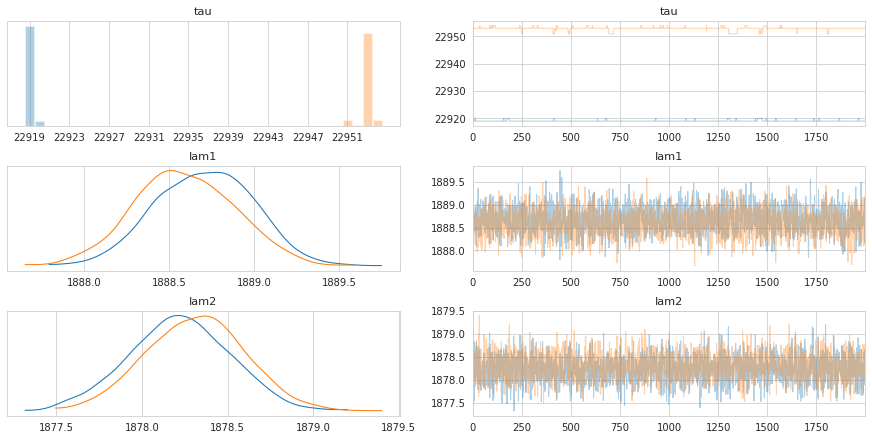

In [ ]:
az.plot_trace(trace_ab);

In [ ]:
az.summary(trace_ab)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,22935.995,16.955,22919.000,22953.000,11.962,10.128,2.0,2.0,2.0,2.0,2.96
lam1,1888.646,0.295,1888.073,1889.157,0.028,0.020,112.0,112.0,118.0,2699.0,1.03
lam2,1878.262,0.292,1877.683,1878.770,0.021,0.015,189.0,189.0,182.0,2817.0,1.02


группа б вроде и значительнее, но тратит меньше, поэтому я бы отдала предпочтение группе а, что обладает слегка большими цифрами в своем интервале, выглядит так, будто дизайн а получается дороже 